In [1]:
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)
%matplotlib inline

my_cmap = plt.cm.jet
my_cmap.set_under('white')

In [2]:
df = pd.read_csv("simple_surr.csv", index_col=0)
df = df.sample(frac=1)

In [3]:
df.magn_len.max()

14.0

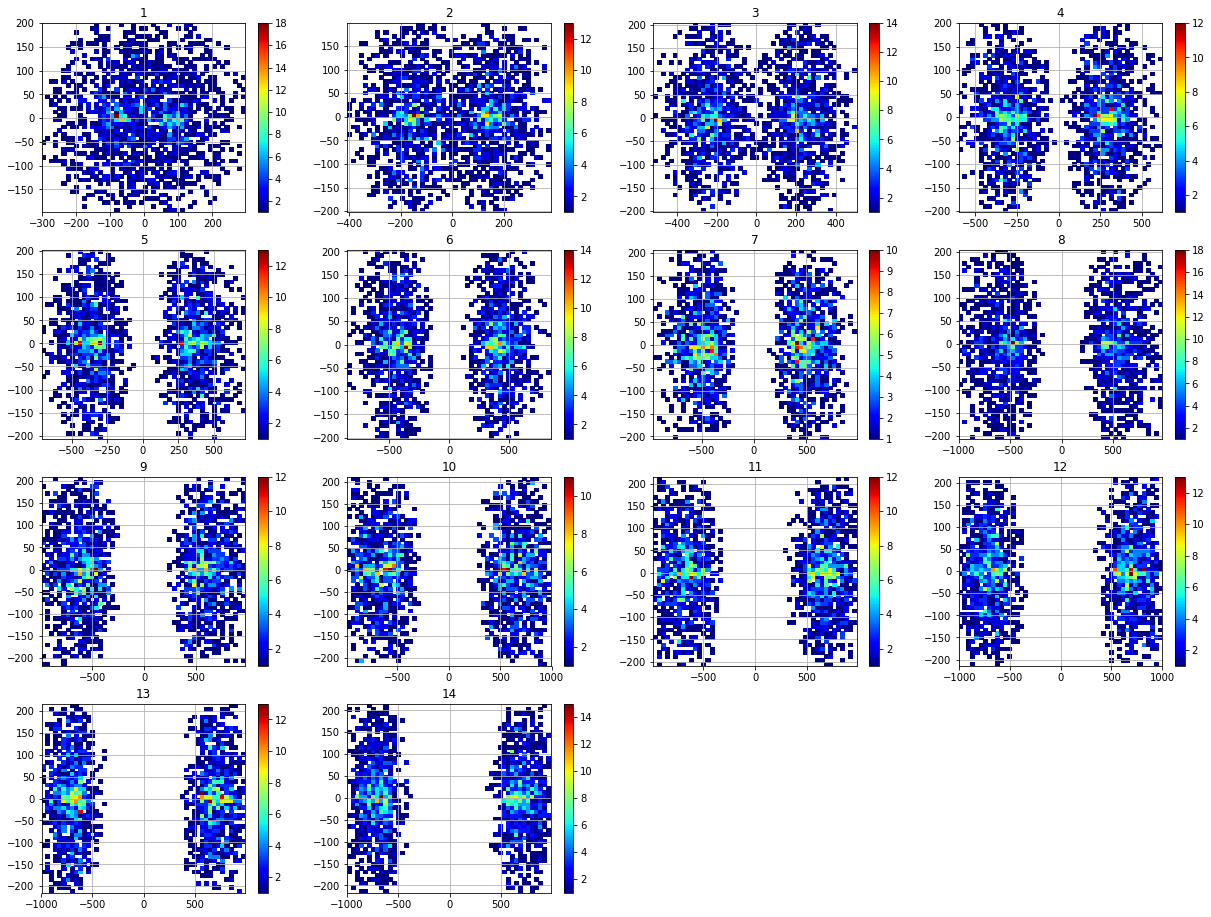

In [33]:
plt.figure(figsize=(21,16))
for i in range(1,15):
    plt.subplot(4,4, i)
    cuts = df[df.magn_len == i]
    plt.hist2d(cuts.hit_x, cuts.hit_y, bins=50,cmap=my_cmap, cmin=1e-10)
    plt.colorbar()
    plt.grid()
    plt.title(f"{i}")

# GAN

In [14]:
from comet_ml import API
import comet_ml

comet_api = API()
comet_api.get()

exp = comet_api.get("shir994/physics-1d/a5602f0a41f84e04b1652096de7fdb83")
hyper_params = {}
for param in exp.parameters:
    hyper_params[param["name"]] = param["valueMin"]

In [19]:
hyper_params['NOISE_DIM'] = int(hyper_params['NOISE_DIM'])
hyper_params['param_dim'] = int(hyper_params['param_dim'])
hyper_params['x_dim'] = int(hyper_params['x_dim'])

In [20]:
from gan import Generator
generator = Generator(hyper_params['NOISE_DIM'], 2, hidden_dim=100,
          input_param=hyper_params['param_dim'] + hyper_params['x_dim']).to(device)

import io

asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == "physics_gan.tar"][0]
params = exp.get_asset(asset_id)
state_dict = torch.load(io.BytesIO(params))
generator.load_state_dict(state_dict['gen_state_dict'])

In [60]:
def sample_noise(N, NOISE_DIM):
    return np.random.normal(size=(N,NOISE_DIM)).astype(np.float32)

def draw_hitmap(n_samples=100):
    f = plt.figure(figsize=(21,16))
    magn_len_arr = np.linspace(1, 5, 16)
    for index in range(16):
        plt.subplot(4,4, index + 1)
        theta = torch.empty(size=[n_samples,1]).uniform_(df.start_theta.min(), df.start_theta.max())
        phi = torch.empty(size=[n_samples,1]).uniform_(df.start_phi.min(), df.start_phi.max())
        p = torch.empty(size=[n_samples,1]).uniform_(df.start_P.min(), df.start_P.max())

        pids = torch.distributions.Bernoulli(probs=0.5).sample([n_samples, 1])
        pids[pids == 1] = 13.
        pids[pids == 0] = -13.

        #magn_len = torch.empty(size=[1, 1], dtype=torch.float32).uniform_(1, 15).repeat([n_samples, 1])
        magn_len = torch.tensor(magn_len_arr[index], dtype=torch.float32).reshape(-1,1).repeat([n_samples, 1])


        noise = torch.Tensor(sample_noise(n_samples, hyper_params['NOISE_DIM'])).to(device)
        distr = generator(noise, torch.cat([pids, theta, phi, p, magn_len], dim=1).to(device)).detach().cpu().numpy()

        plt.hist2d(distr[:,0], distr[:, 1], bins=50, cmap=my_cmap, cmin=1e-10)
        plt.grid()
        plt.colorbar()
        plt.title("len={:.2f}".format(magn_len[0,0].item()), fontsize=15)
    return f

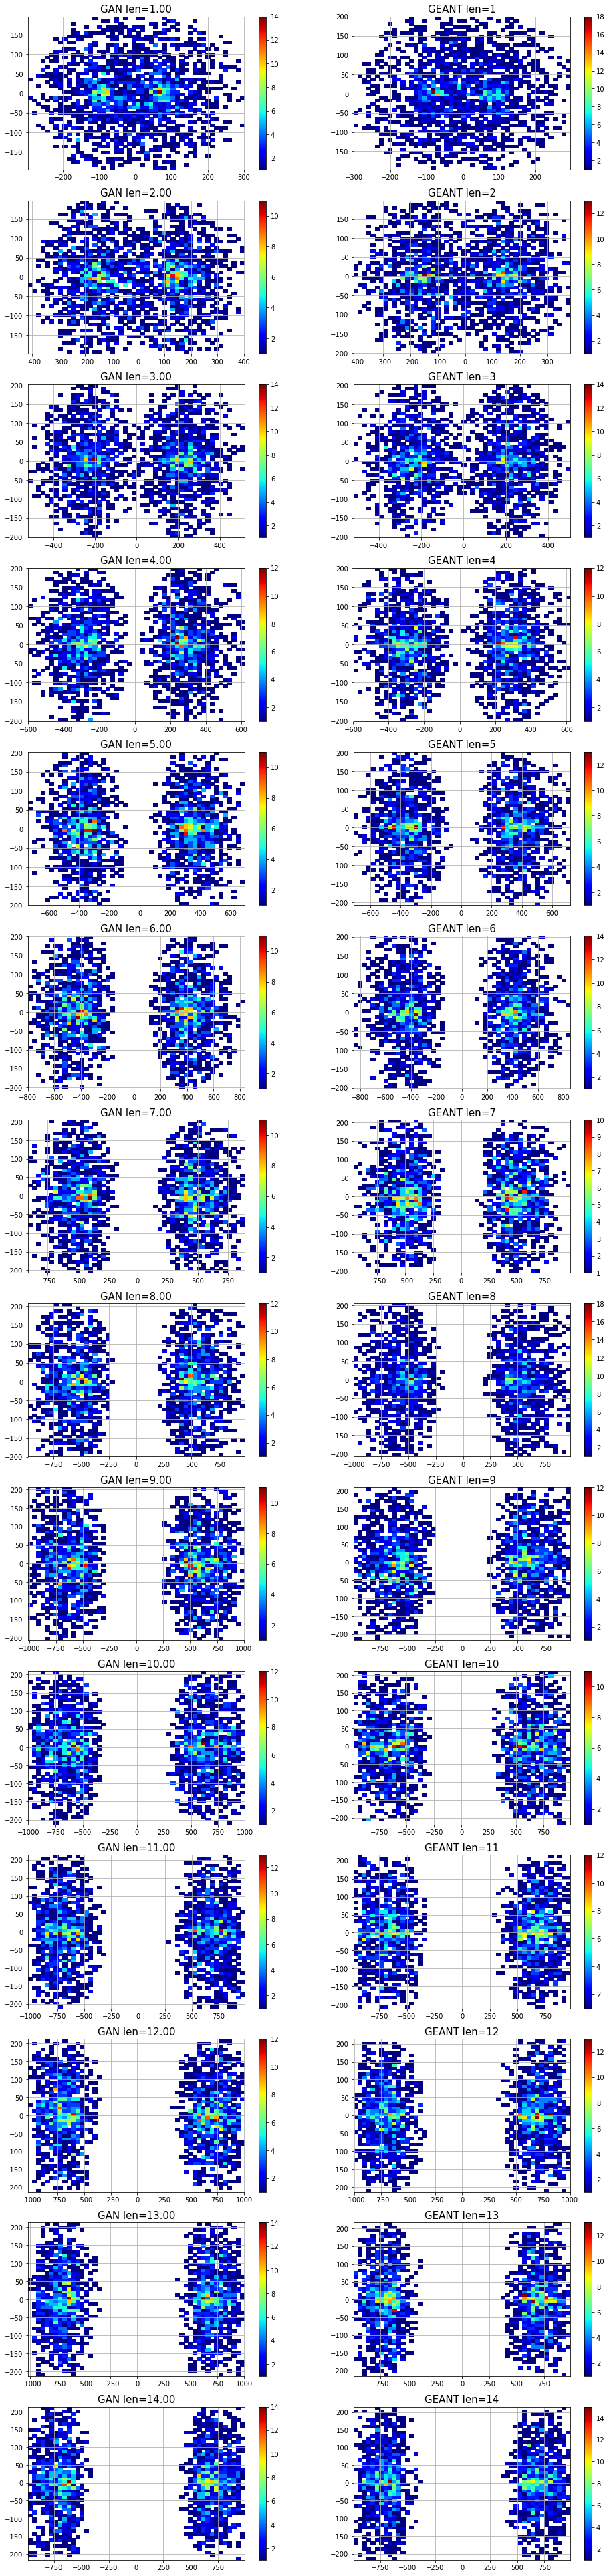

In [64]:
n_samples=2000
f = plt.figure(figsize=(16,70))
for index in range(14):
    theta = torch.empty(size=[n_samples,1]).uniform_(df.start_theta.min(), df.start_theta.max())
    phi = torch.empty(size=[n_samples,1]).uniform_(df.start_phi.min(), df.start_phi.max())
    p = torch.empty(size=[n_samples,1]).uniform_(df.start_P.min(), df.start_P.max())

    pids = torch.distributions.Bernoulli(probs=0.5).sample([n_samples, 1])
    pids[pids == 1] = 13.
    pids[pids == 0] = -13.

    #magn_len = torch.empty(size=[1, 1], dtype=torch.float32).uniform_(1, 15).repeat([n_samples, 1])
    magn_len = torch.tensor(index+ 1, dtype=torch.float32).reshape(-1,1).repeat([n_samples, 1])


    noise = torch.Tensor(sample_noise(n_samples, hyper_params['NOISE_DIM'])).to(device)
    distr = generator(noise, torch.cat([pids, theta, phi, p, magn_len], dim=1).to(device)).detach().cpu().numpy()

    plt.subplot(14,2, 2*index + 1)
    plt.hist2d(distr[:,0], distr[:, 1], bins=50, cmap=my_cmap, cmin=1e-10)
    plt.grid()
    plt.title("GAN len={:.2f}".format(magn_len[0,0].item()), fontsize=15)
    plt.colorbar()
    plt.subplot(14,2, 2*index + 2)
    cuts = df[df.magn_len == index+1]
    plt.hist2d(cuts.hit_x, cuts.hit_y, bins=50,cmap=my_cmap, cmin=1e-10)
    plt.grid()
    plt.title(f"GEANT len={index+1}", fontsize=15)
    plt.colorbar()
plt.savefig("true_gan.pdf")

### Interpolation

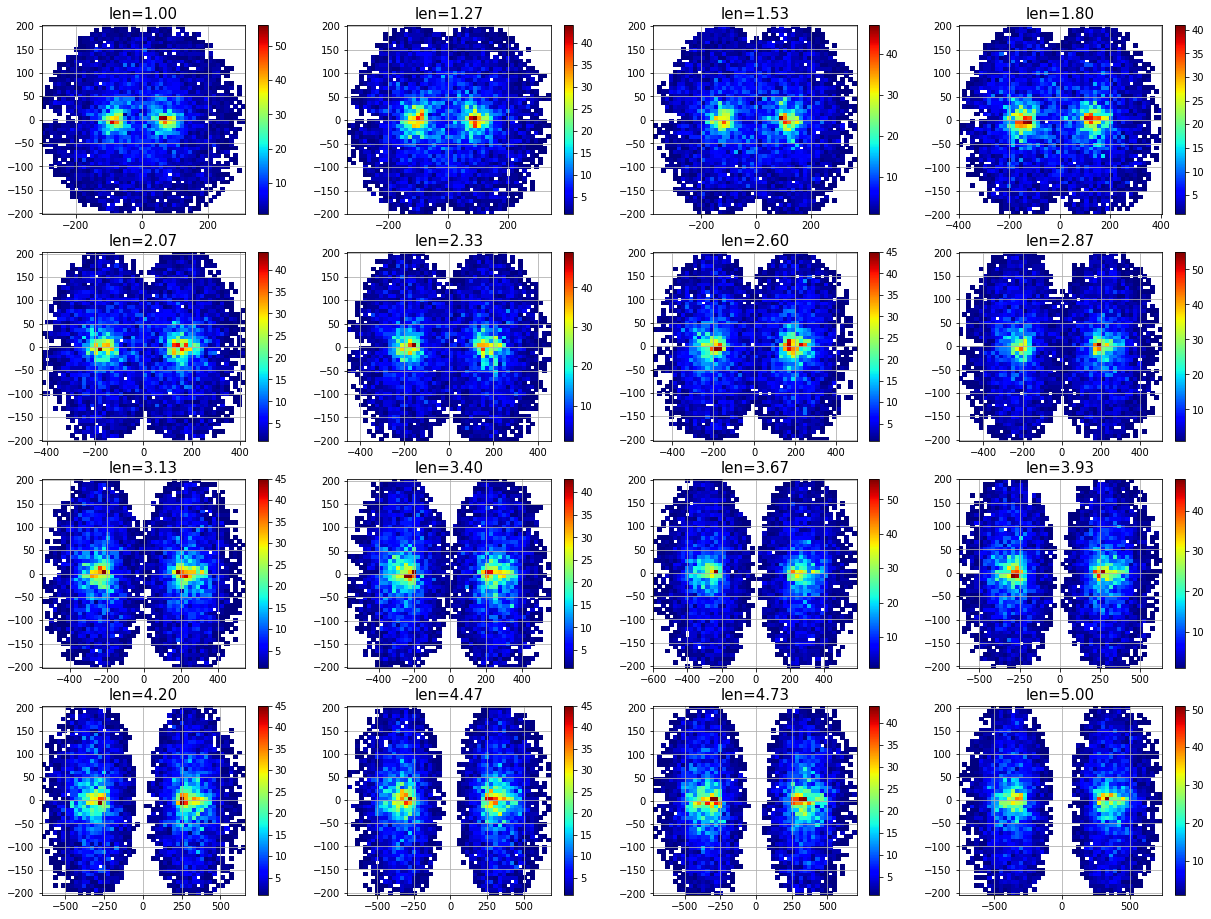

In [66]:
draw_hitmap(n_samples=10000)
plt.savefig("interpolation.pdf")
plt.show()

# Optimisation

In [94]:
def SigmoidLoss(ys: torch.tensor, left_bound, right_bound):
    return torch.prod(torch.sigmoid(ys - left_bound) - torch.sigmoid(ys - right_bound), dim=1)

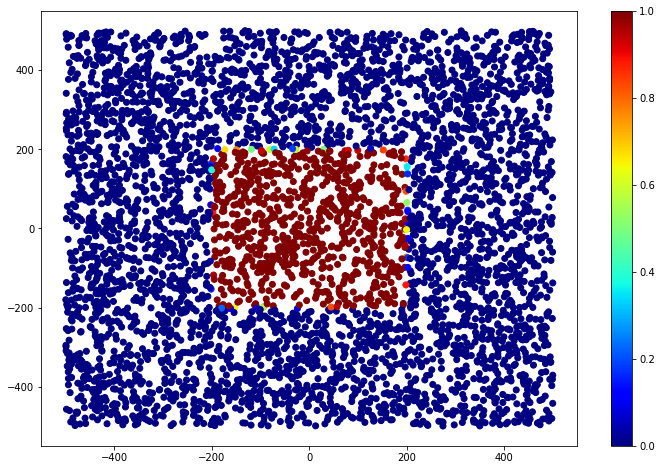

In [95]:
f = plt.figure(figsize=(12,8))
x = torch.tensor(np.random.uniform(-500, 500, 5000))
y = torch.tensor(np.random.uniform(-500, 500, 5000))

preds = torch.cat([x.reshape(-1,1),y.reshape(-1,1)], dim=1)
plt.scatter(x,y, c=SigmoidLoss(preds, -200, 200), cmap=my_cmap)
plt.colorbar()

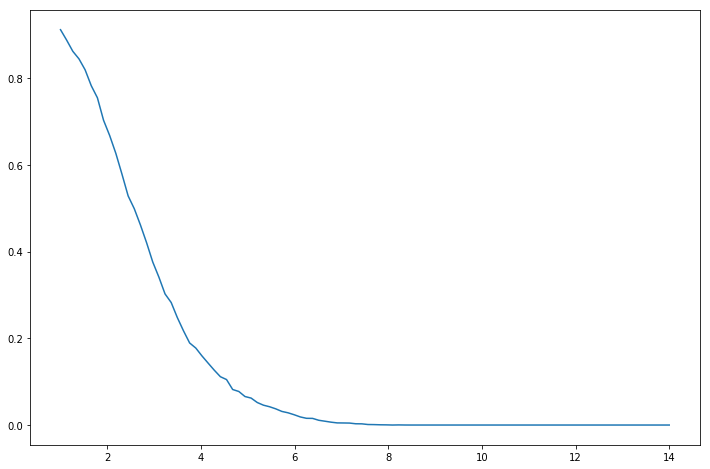

In [192]:
n_samples=10000
losses = []
mu_space = np.linspace(1, 14, 100)
for index in range(100):
    theta = torch.empty(size=[n_samples,1]).uniform_(df.start_theta.min(), df.start_theta.max())
    phi = torch.empty(size=[n_samples,1]).uniform_(df.start_phi.min(), df.start_phi.max())
    p = torch.empty(size=[n_samples,1]).uniform_(df.start_P.min(), df.start_P.max())

    pids = torch.distributions.Bernoulli(probs=0.5).sample([n_samples, 1])
    pids[pids == 1] = 13.
    pids[pids == 0] = -13.

    #magn_len = torch.empty(size=[1, 1], dtype=torch.float32).uniform_(1, 15).repeat([n_samples, 1])
    magn_len = torch.tensor(mu_space[index], dtype=torch.float32).reshape(-1,1).repeat([n_samples, 1])


    noise = torch.Tensor(sample_noise(n_samples, hyper_params['NOISE_DIM'])).to(device)
    distr = generator(noise, torch.cat([pids, theta, phi, p, magn_len], dim=1).to(device)).detach().cpu()#.numpy()
    losses.append(SigmoidLoss(distr, -200, 200).mean().item())

(0, 0.05)

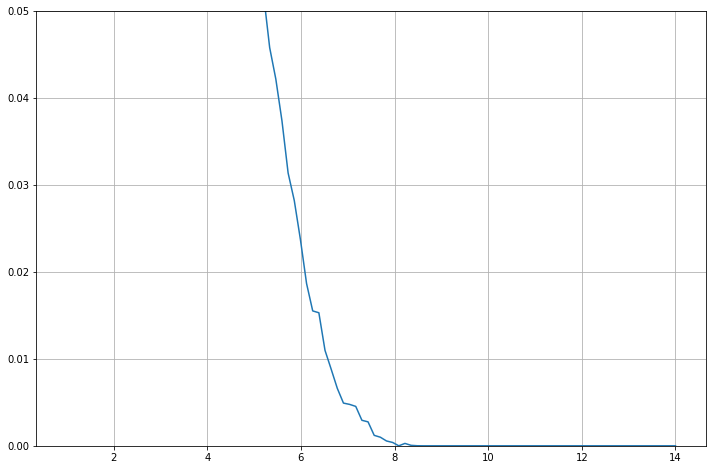

In [196]:
plt.figure(figsize=(12,8))
plt.plot(mu_space, losses)
plt.grid()

In [103]:
from copy import deepcopy

class InputOptimisation(nn.Module):
    def __init__(self, generator_model):
        super().__init__()
        self.gen = deepcopy(generator_model)
        for param in self.gen.parameters():
            param.requires_grad = False
        self.gen.eval()
       
    def forward(self, noise, inputs):
        return self.gen(noise, inputs)
    
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')    

In [185]:
io_model = InputOptimisation(generator).to(device)

lr = 0.1

mu_optim = torch.tensor([1.]).reshape(1,-1)
mu_optim = mu_optim.repeat(n_samples, 1)#.to(device)
mu_optim.requires_grad=True

In [186]:
%%time
n_iter = 5000
losses = []
m_vals = [mu_optim[0, :].detach().cpu().numpy()[0]]
for _iter in range(n_iter):
    theta = torch.empty(size=[n_samples,1]).uniform_(df.start_theta.min(), df.start_theta.max())
    phi = torch.empty(size=[n_samples,1]).uniform_(df.start_phi.min(), df.start_phi.max())
    p = torch.empty(size=[n_samples,1]).uniform_(df.start_P.min(), df.start_P.max())

    pids = torch.distributions.Bernoulli(probs=0.5).sample([n_samples, 1])
    pids[pids == 1] = 13.
    pids[pids == 0] = -13.

    noise = torch.Tensor(sample_noise(n_samples, hyper_params['NOISE_DIM'])).to(device)
    distr = generator(noise, torch.cat([pids, theta, phi, p, mu_optim], dim=1).to(device))

    loss = SigmoidLoss(distr, -200, 200).mean() * n_samples
    losses.append(loss.item())
    io_model.zero_grad()
    loss.backward()
    with torch.no_grad():
        mu_optim -= lr * mu_optim.grad.mean(dim=0, keepdim=True)
        mu_optim.grad.zero_()
    m_vals.append(mu_optim[0, :].detach().cpu().numpy()[0])
m_vals =np.array(m_vals)    

CPU times: user 44.4 s, sys: 1.51 s, total: 45.9 s
Wall time: 45.8 s


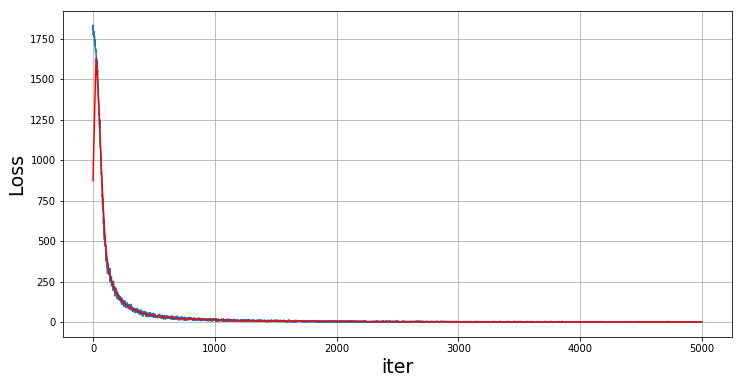

In [187]:
plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iter", fontsize=19)
plt.plot((movingaverage(losses, 50)), c='r')

Text(0.5, 0, 'iter')

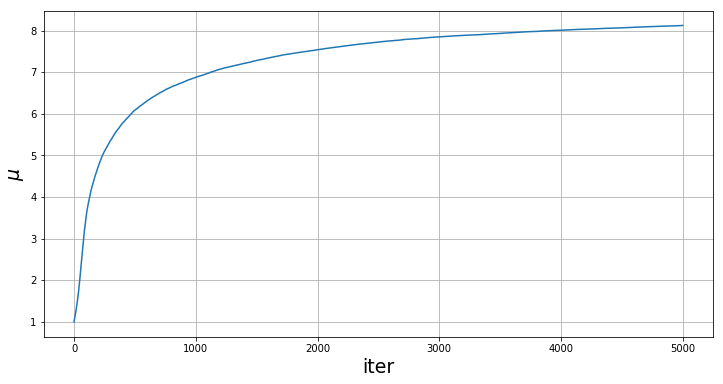

In [188]:
plt.figure(figsize=(12,6))
plt.plot(m_vals);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)